In [1]:
import numpy as np
import matplotlib.pyplot as plt
from constants import IMAGES_DIR

def plot_time_domain(audio, fs, chart_title="Audio Signal in Time Domain", save=False):
    time = np.arange(0, len(audio)/fs, 1/fs)
    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(time, audio)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(chart_title)
    if save:
        plt.savefig(f"{IMAGES_DIR}/{chart_title}.png", dpi=100)
    plt.show()
    

def plot_magnitude_spectrum(audio, fs, show_negative=True, chart_title="Audio Spectrum in Frequency Domain", save=False):
    # Flatten the audio if it's 2D
    if audio.ndim > 1:
        audio = audio.flatten()
    
    N = len(audio)
    if show_negative:
        freq = np.fft.fftfreq(N, 1/fs)  # Both positive and negative frequencies
        audio_fft = np.fft.fft(audio)
    else:
        freq = np.fft.rfftfreq(N, 1/fs)  # Only positive frequencies
        audio_fft = np.fft.rfft(audio)  # real signals
    
    # Normalize magnitude 
    # regardless of the magnitude of the signal
    magnitude = np.abs(audio_fft) / N  

    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(freq, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(chart_title)
    plt.grid()
    if save:
        plt.savefig(f"{IMAGES_DIR}/{chart_title}.png", dpi=100)
    plt.show()
    


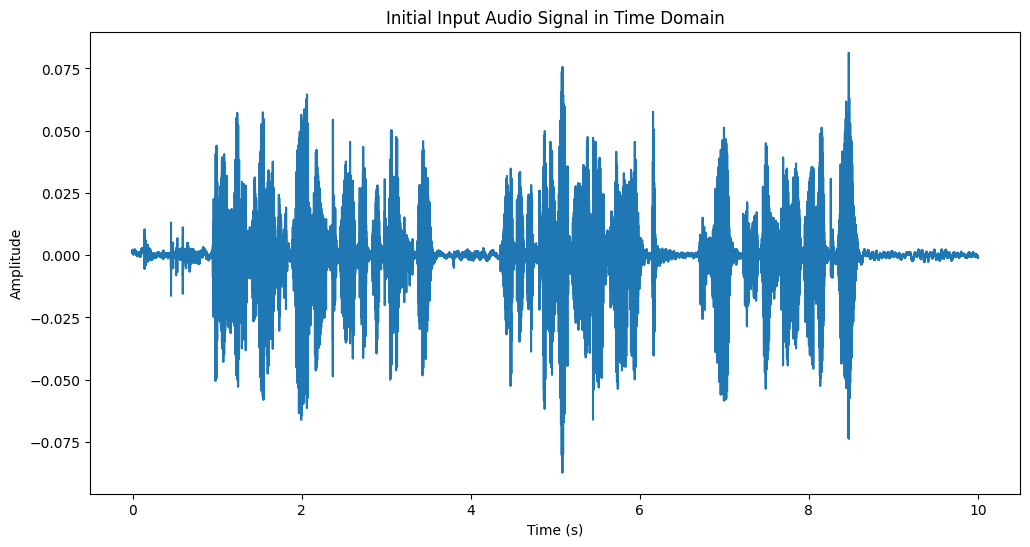

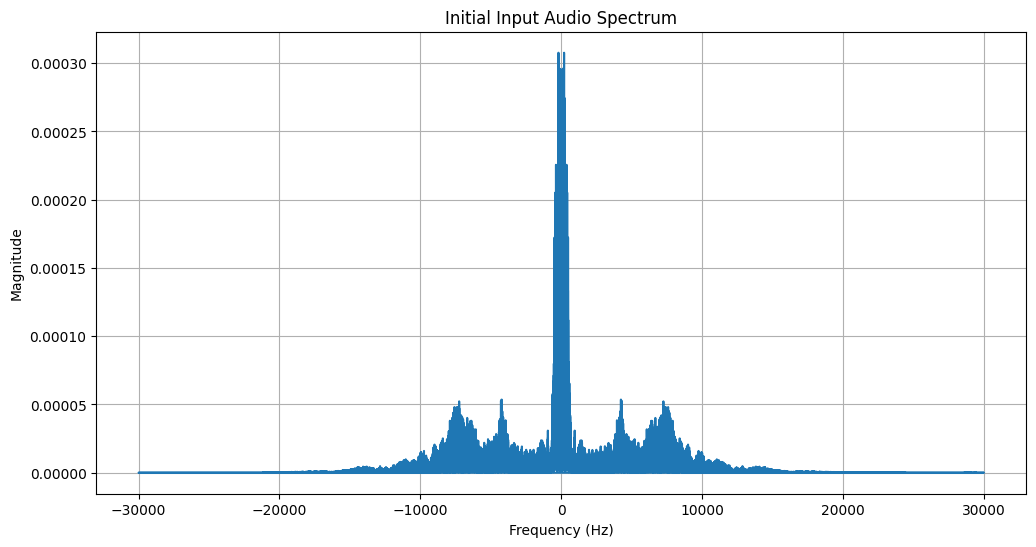

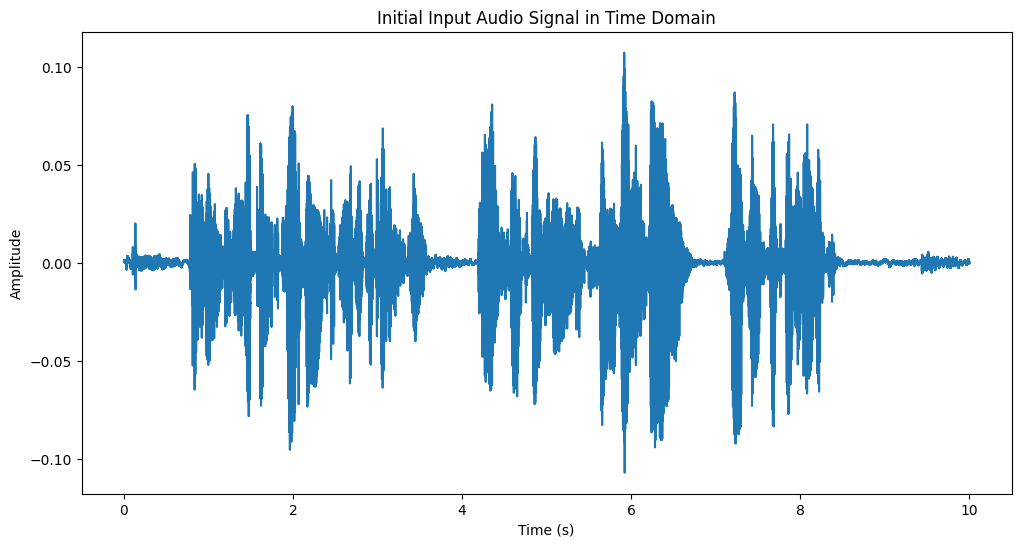

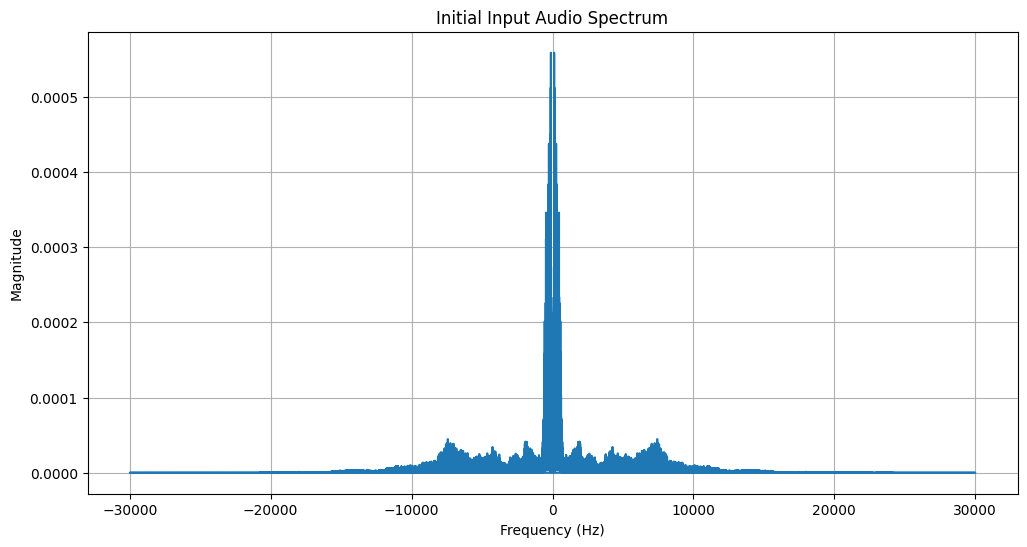

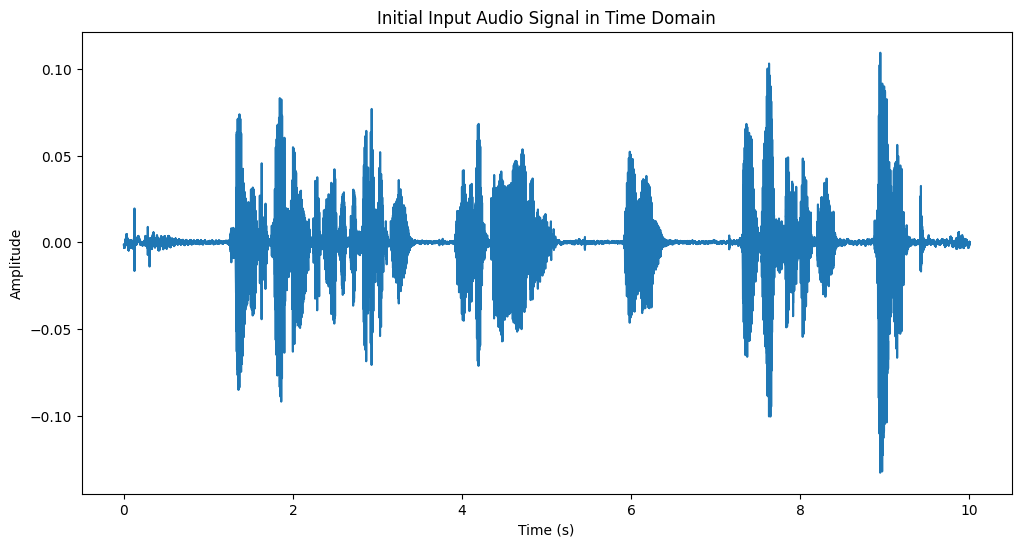

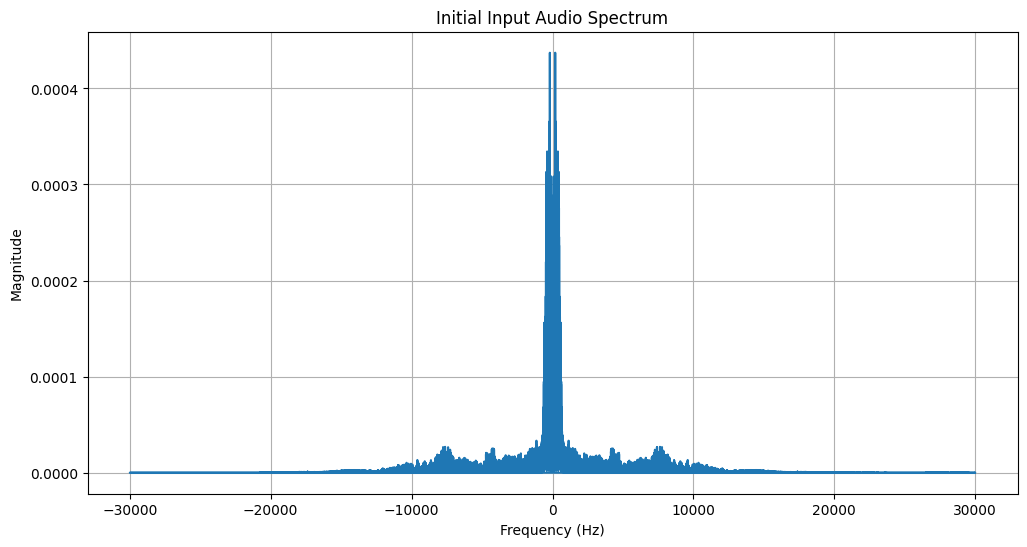

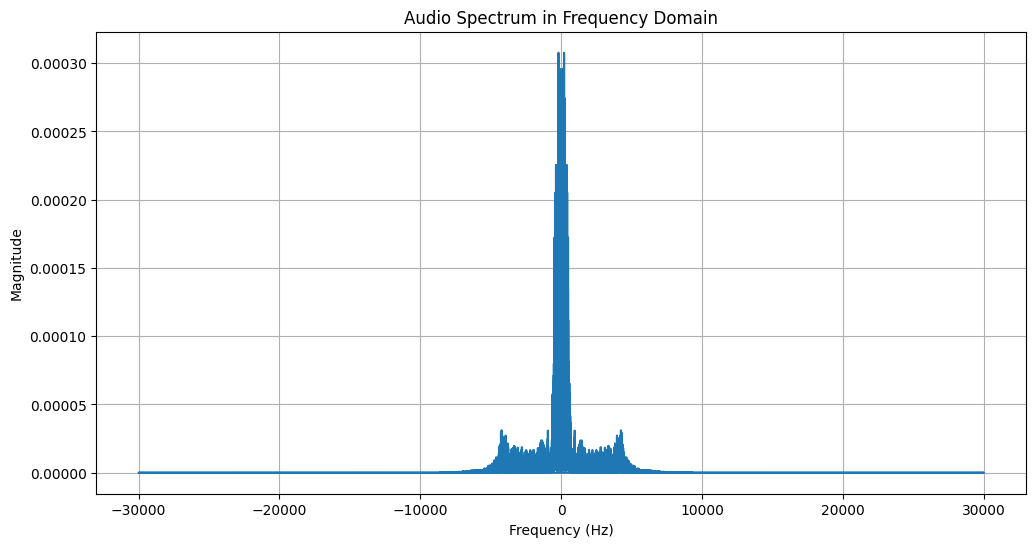

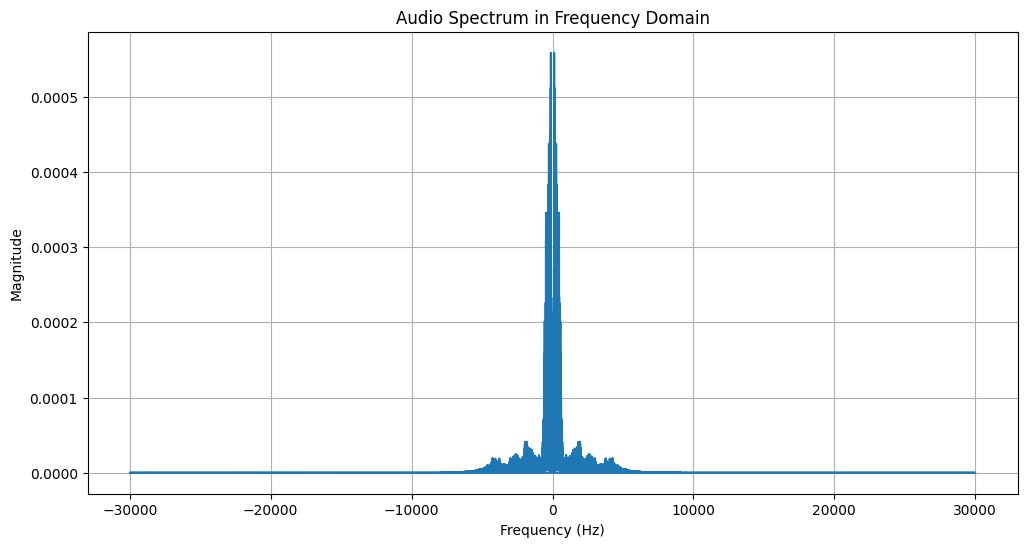

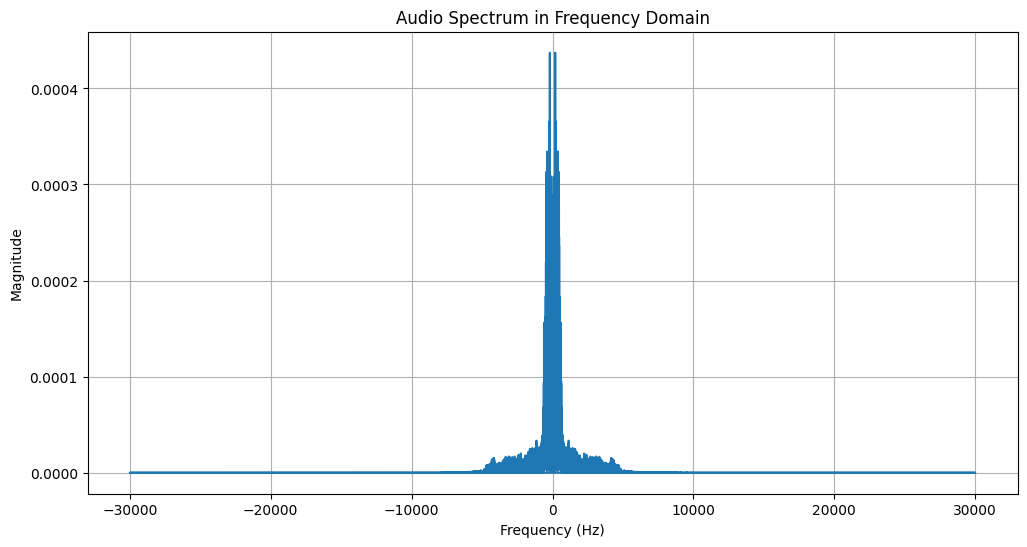

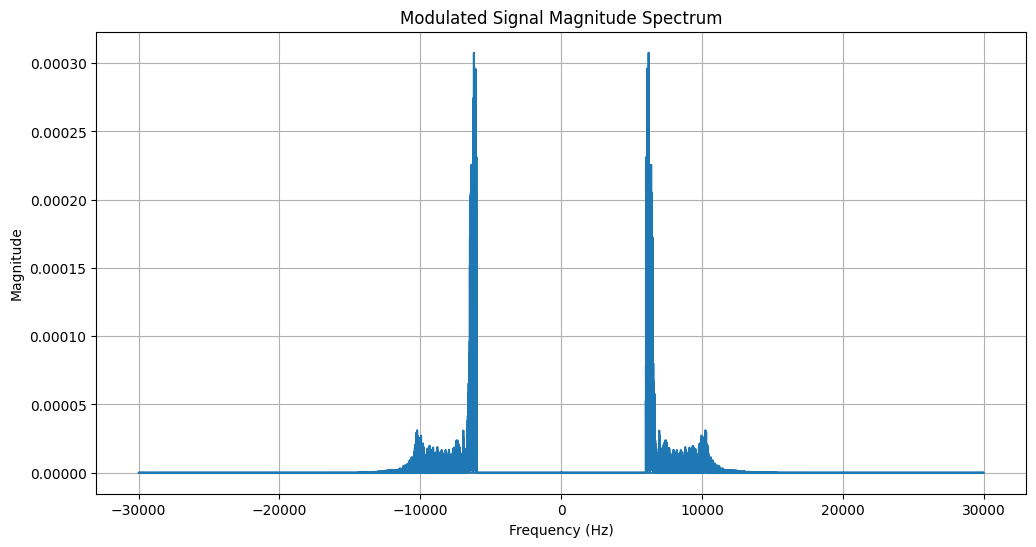

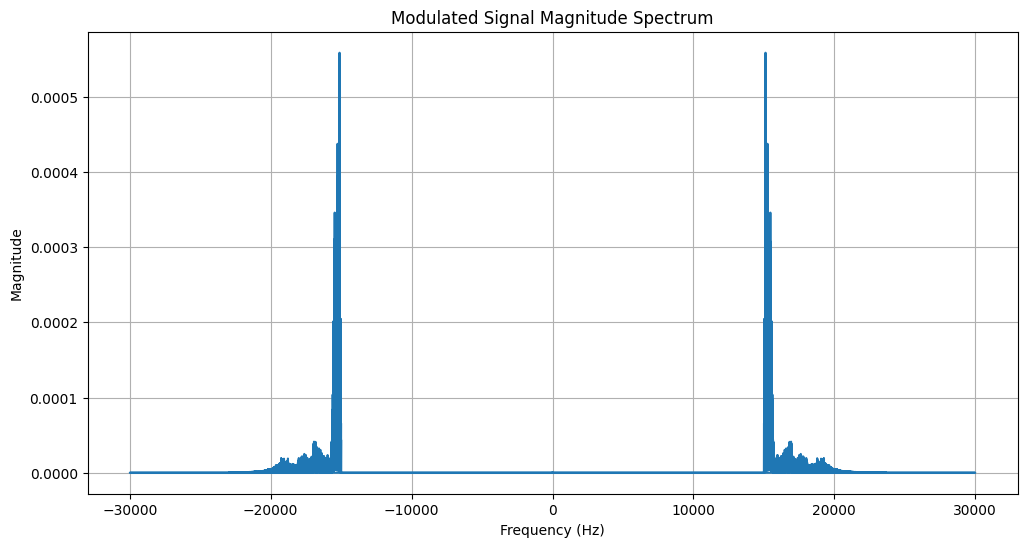

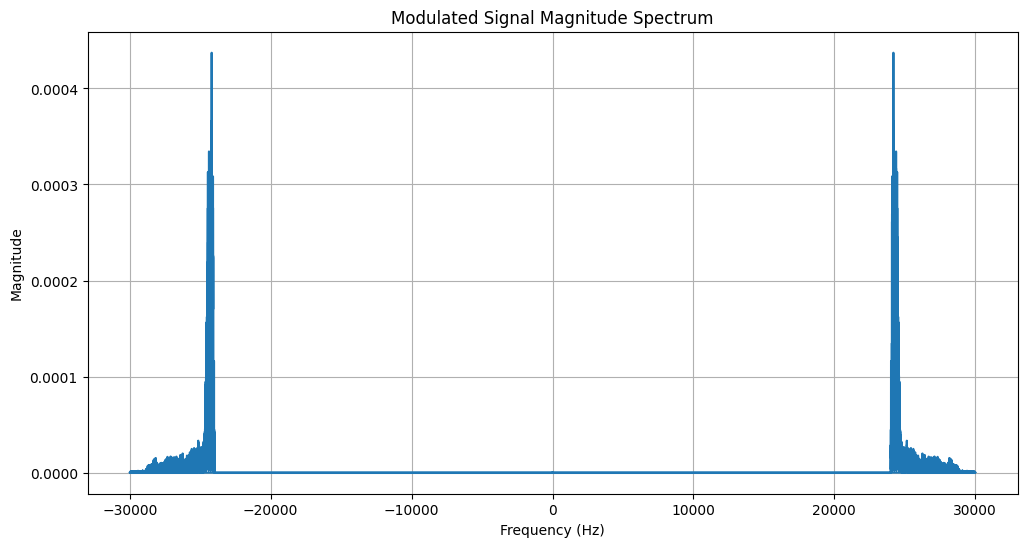

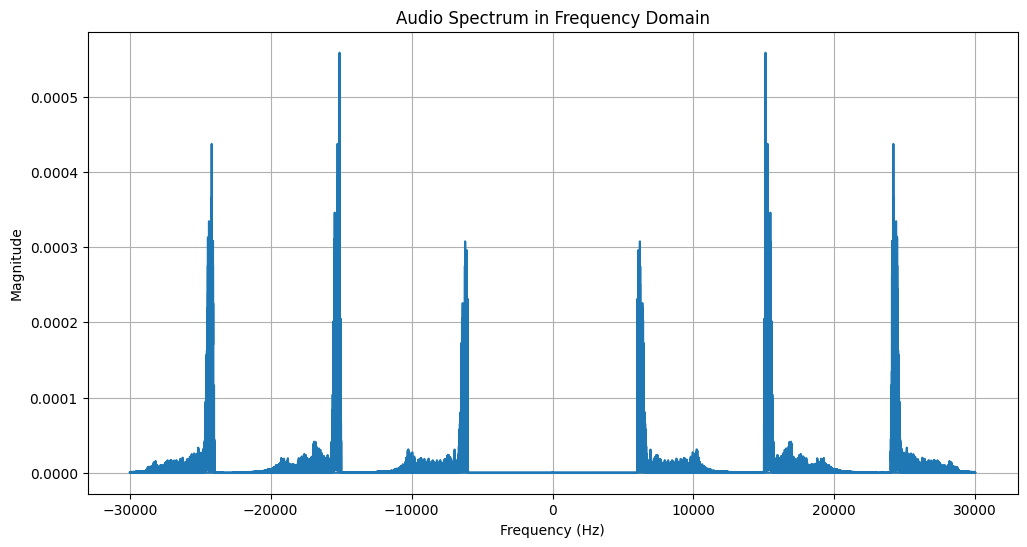

Signal saved to ./recordings/output/output1.wav


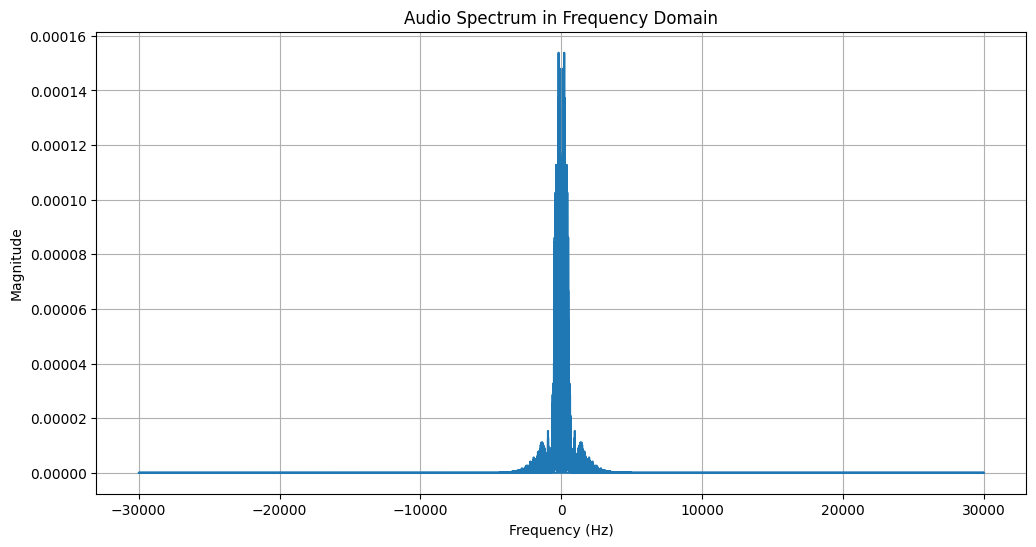

Signal saved to ./recordings/output/output2.wav


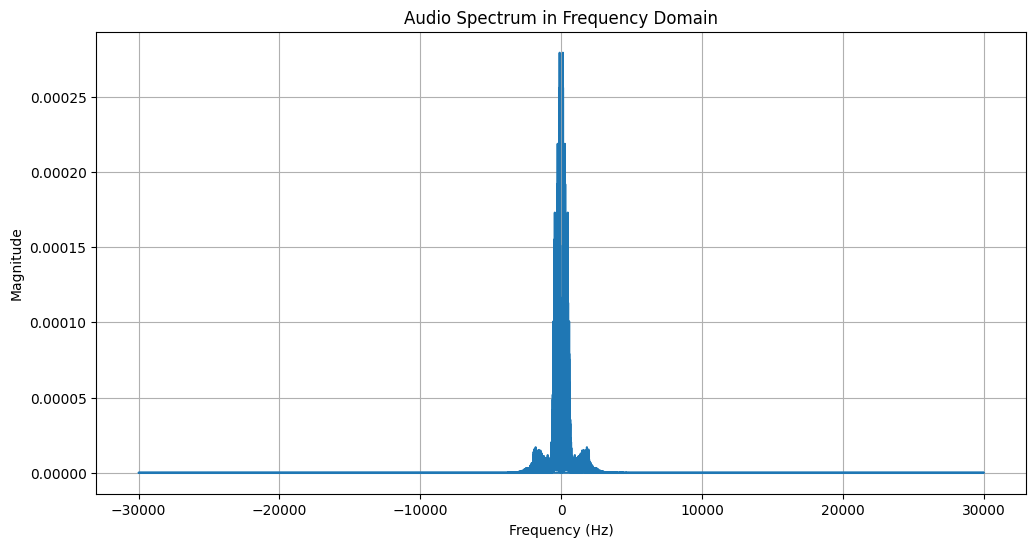

Signal saved to ./recordings/output/output3.wav


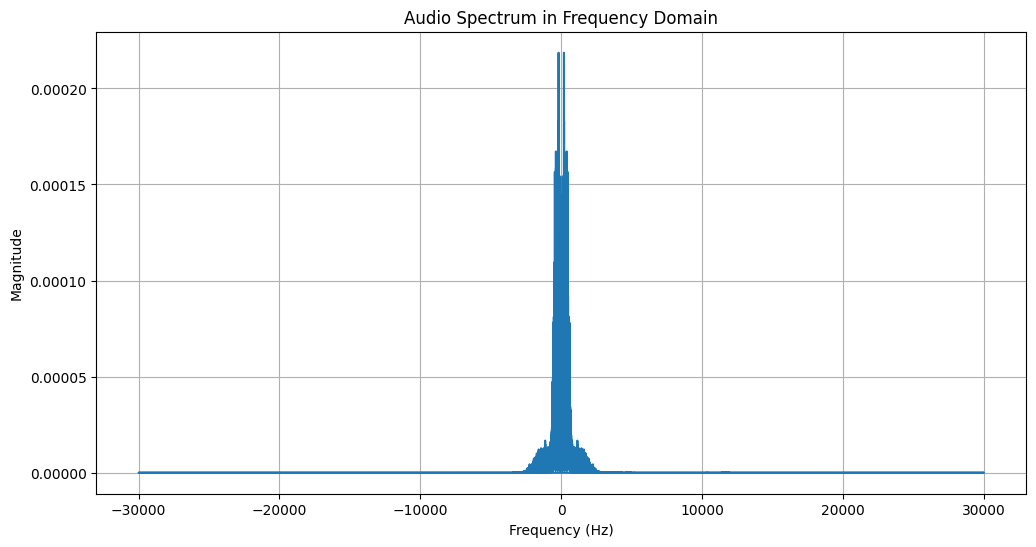

In [18]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert
import soundfile as sf
import matplotlib.pyplot as plt

from processing import save_signal_to_file

def apply_lpf(signal, sample_rate, cutoff):
    nyquist = sample_rate / 2
    b, a = butter(4, cutoff / nyquist, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def custom_hilbert(signal):

    N = len(signal)
    signal_fft = np.fft.fft(signal)
    
    # Create a frequency mask
    h = np.zeros(N)
    if N % 2 == 0:
        h[0] = 1
        h[1:N//2] = 2
        h[N//2] = 1
    else:
        h[0] = 1
        h[1:(N+1)//2] = 2
    
    analytic_signal = np.fft.ifft(signal_fft * h)
    return analytic_signal

def apply_bandpass(signal, sample_rate, lowcut, highcut):
    nyquist = sample_rate / 2
    b, a = butter(4, [lowcut / nyquist, highcut / nyquist], btype='band')
    bandpassed_signal = filtfilt(b, a, signal)
    return bandpassed_signal


def ssb_modulate(signal, carrier_freq, sample_rate):

    t = np.arange(len(signal)) / sample_rate
    carrier = np.cos(2 * np.pi * carrier_freq * t)
    
    # Compute the analytic signal
    analytic_signal = custom_hilbert(signal)
    
    # SSB modulation (upper sideband)
    ssb_signal = np.real(analytic_signal * np.exp(1j * 2 * np.pi * carrier_freq * t))
    
    return ssb_signal


def ssb_demodulate(ssb_signal, carrier_freq, sample_rate):
   
    t = np.arange(len(ssb_signal)) / sample_rate
    carrier = np.cos(2 * np.pi * carrier_freq * t)
    
    # Multiply by the carrier signal to shift the spectrum back to baseband
    demodulated = ssb_signal * carrier
    
    # Apply a custom low-pass filter to remove the high-frequency components
   
    
    return demodulated


# Load the recorded audio signals
input_files = ['./recordings/input/input1.wav', './recordings/input/input2.wav', './recordings/input/input3.wav']
recorded_signals = []
sample_rate = None
for file in input_files:
    audio, sample_rate = sf.read(file)
    
    
    plot_time_domain(audio, sample_rate, chart_title="Initial Input Audio Signal in Time Domain", save=True)
    plot_magnitude_spectrum(audio, sample_rate, chart_title="Initial Input Audio Spectrum", save=True)
    recorded_signals.append(audio.flatten())

# Apply low-pass filter
filtered_signals = []
cutoff_freq = 4400  # Example cutoff frequency
for i, signal in enumerate(recorded_signals):
    filtered = apply_lpf(signal, sample_rate, cutoff_freq)
    filtered_signals.append(filtered)
    plot_magnitude_spectrum(filtered, sample_rate, f'Filtered Signal {i+1}')

# Perform SSB Modulation
carrier_frequencies = [6000, 15000, 24000]  # Example carrier frequencies
modulated_signals = []
for i, (signal, carrier) in enumerate(zip(filtered_signals, carrier_frequencies)):
    modulated = ssb_modulate(signal, carrier, sample_rate)
    
    plot_magnitude_spectrum(modulated, sample_rate, chart_title="Modulated Signal Magnitude Spectrum", save=True)
    modulated_signals.append(modulated)

# Combine modulated signals for FDM
fdm_signal = np.sum(modulated_signals, axis=0)
plot_magnitude_spectrum(fdm_signal, sample_rate, 'FDM Signal')

# Save modulated signals
for i, modulated in enumerate(modulated_signals):
    sf.write(f'./recordings/output/modulated_signal_{i+1}.wav', modulated, sample_rate)

# Perform SSB Demodulation
output_files = ['./recordings/output/output1.wav', './recordings/output/output2.wav', './recordings/output/output3.wav']
demodulated_signals = []
for i, (carrier, file) in enumerate(zip(carrier_frequencies, output_files)):
       # Apply bandpass filter to isolate the desired signal
    lowcut = carrier - cutoff_freq /2  # Adjust band edges as needed
    highcut = carrier + cutoff_freq/2
    bandpassed_signal = apply_bandpass(fdm_signal, sample_rate, lowcut, highcut)
    demodulated = ssb_demodulate(bandpassed_signal, carrier, sample_rate)
   


    # Apply low-pass filter after demodulation
    recovered_signal = apply_lpf(demodulated, sample_rate, cutoff_freq)
    demodulated_signals.append(recovered_signal)
    save_signal_to_file(recovered_signal, sample_rate, file)
    # sf.write(file, recovered_signal, sample_rate)
    plot_magnitude_spectrum(recovered_signal, sample_rate, f'Demodulated Signal {i+1}')
